## Expected Free Energy for oscillator with nonlinear observations

Wouter Kouw, last update: 20-11-2022

### System

Consider a [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators) with displacement $x(t)$, driving force $u(t)$ and noise $w(t)$. The continuous-time dynamics of the system are:

$$\begin{align*}
m \frac{d^2 x(t)}{dt^2} =&\ - c \frac{d x(t)}{dt} - k x(t) + u(t) + w(t)\, ,
\end{align*}$$
where 
$$
m     = \text{mass} \, , \quad
c     = \text{damping} \, , \quad
k     = \text{spring stiffness} 
$$
constitute the physical parameters. 

#### Multivariate first-order system

We will first adopt a more concise notation and then divide by the leading coefficient:

$$ x'' = \frac{-c}{m} x' + \frac{-k}{m} x + \frac{1}{m} u + \frac{1}{m} w \, .$$

With the variable substitution $z = [x \ x']$, I cast the above system into a multi-variate first-order form:

$$ \begin{bmatrix} x' \\ x'' \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} \begin{bmatrix} x \\ x' \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w\, .$$

#### Discretization

For the Van Loan discretization of the Wiener process, I first consider a first-order approximation of the matrix exponential of the transition matrix: 

$$F(t) = I + \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} t \, .$$

Then, I will consider the continuous-time covariance matrix of the noise in multi-variate form:

$$\mathbb{V}[\begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w] = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} \mathbb{V}[w] \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}^{\top} = \begin{bmatrix} 0 & 0 \\ 0 & \frac{\sigma^2}{m^2} \end{bmatrix} \triangleq V \, .$$

Now, I can integrate the evolution of the covariance matrix from over the duration of a time-step. If all time-steps are equally long, e.g., of size $\Delta t$, then

$$Q = \int_0^{\Delta t} F(t) V F(t)^{\top} dt = \frac{\sigma^2}{m^2} \begin{bmatrix} \frac{\Delta t^3}{3} & \frac{-c}{m}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} \\ \frac{-c}{m}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} & \frac{c^2}{m^2}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} + \Delta t \end{bmatrix} \, ,$$

where $\sigma^2 = \mathbb{V}[w]$. A forward Euler discretization for the state transition yields:

$$\begin{align*} 
\left( \begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} - \begin{bmatrix} x_{k} \\ x'_{k} \end{bmatrix} \right) / \Delta t =&\ \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u_k \, ,
\end{align*}$$

So, we end up with:

$$\begin{align*}
z_k =&\ \underbrace{\begin{bmatrix} 1 & \Delta t \\ \frac{-k}{m} \Delta t & \frac{-c}{m} \Delta t + 1 \end{bmatrix}}_{A} z_{k-1} + \underbrace{\begin{bmatrix} 0 \\ \frac{1}{m} \Delta t \end{bmatrix}}_{B} u_k + q_k \quad \text{where} \quad q_k \sim \mathcal{N}(0,Q) \, .
\end{align*}$$

We have noisy observations of a nonlinear function $g$ of the displacement, 

$$ y_k = g(z_k) + r_k \quad \text{where} \quad r_k \sim \mathcal{N}(0, R) \, .$$

This gives an overall probabibilistic state-space model of the form:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid g(z_k), R) \, .
\end{align}$$

We can simulate the behaviour of this system as follows:

In [1]:
# using Pkg
# Pkg.activate(".")
# Pkg.instantiate()

In [1]:
using Revise
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)

In [47]:
# System parameters
mass = 0.5
friction = 0.3
stiffness = 1.0

# Substituted parameters
θ1_true = -stiffness/mass
θ2_true = -friction/mass
θ3_true = 1/mass
θ_true = [θ1_true, θ2_true, θ3_true]

# Temporal variables
Δt = 0.01
time = range(0, step=Δt, stop=5.0)
len_time = length(time)

# Matrices
A = [1 Δt; θ1_true*Δt θ2_true*Δt+1]
B = [0, θ3_true*Δt]
C = [1, 0]

# Inverse functions for parameters
g1(y,x,u, θ2, θ3) = (y[2] - (Δt*θ2+1)*x[2] - Δt*θ3*u)/(Δt*x[1])
g2(y,x,u, θ1, θ3) = (y[2] - Δt*θ1*x[1] - Δt*θ3*u)/(Δt*x[2]) - 1/Δt
g3(y,x,u, θ1, θ2) = (y[2] - Δt*θ1*x[1] - (Δt*θ2 + 1)*x[2])/(Δt*u)
    
# Measurement noise
R = 1e-3;

In [48]:
function update(z_kmin1, u_k)
   "Update environment" 
    
    # State transition
    z_k = A*z_kmin1 + B*u_k
    
    # Emit noisy observation
    y_k = rand(Normal(dot(C,z_k), sqrt(R)))
    
    return y_k, z_k
end;

In [58]:
# Control
u = sin.(time)

501-element Vector{Float64}:
  0.0
  0.009999833334166664
  0.01999866669333308
  0.02999550020249566
  0.03998933418663416
  0.04997916927067833
  0.059964006479444595
  0.06994284733753277
  0.0799146939691727
  0.08987854919801104
  0.09983341664682815
  0.10977830083717481
  0.11971220728891936
  ⋮
 -0.9842685830120416
 -0.9824526126243325
 -0.9805383977940689
 -0.9785261299411385
 -0.9764160102906497
 -0.9742082498528091
 -0.9719030694018208
 -0.9695006994538088
 -0.967001380243766
 -0.9644053617015305
 -0.9617129034267934
 -0.9589242746631385

In [59]:
# Initial state
z_0 = [0.0, 0.0]

# Preallocate
z = zeros(2,len_time)
y = zeros(len_time)

# Start recursion
z_kmin1 = z_0
for k in 1:len_time
    
    # Update system
    y[k], z[:,k] = update(z_kmin1, u[k])
    
    # Update recursion
    z_kmin1 = z[:,k]
    
end

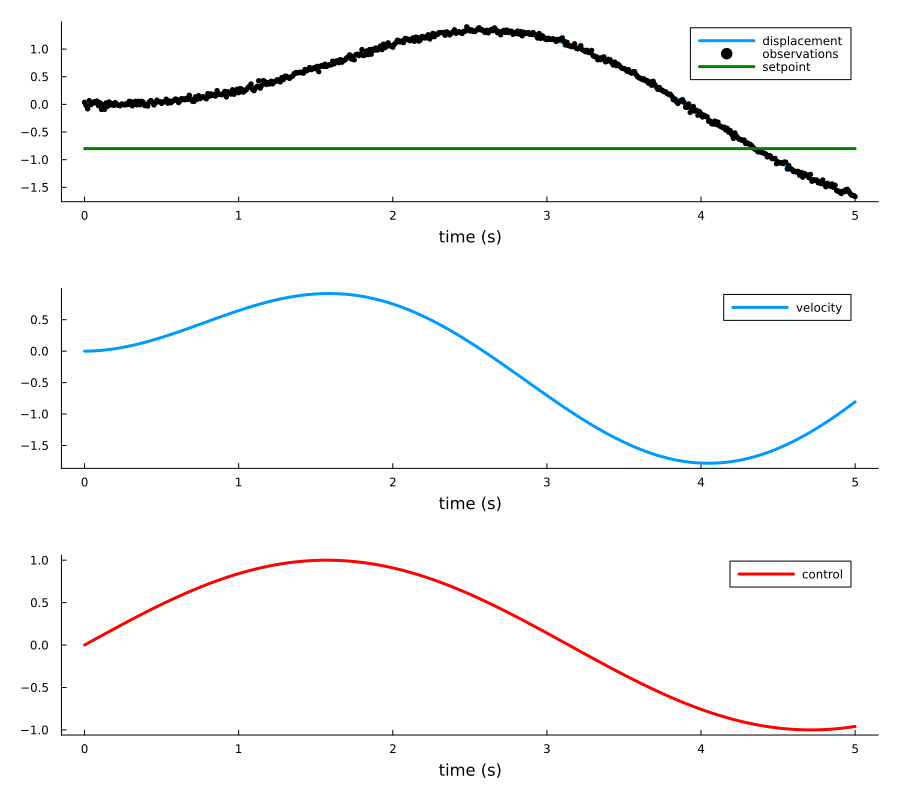

In [60]:
p1 = plot(time, z[1,:], xlabel="time (s)", label="displacement")
scatter!(time, y, color="black", label="observations")
plot!(time, y_star*ones(len_time), color="green", label="setpoint")
p2 = plot(time, z[2,:], xlabel="time (s)", label="velocity")
p3 = plot(time, u, color="red", xlabel="time (s)", label="control")
plot(p1, p2, p3, layout=(3,1), size=(900,800))

In [65]:
# Num samples for particle filter
n_samples = 10

# Preallocate
z_est = (zeros(2,len_time), zeros(2,2,len_time))
θ_est = (zeros(3,len_time), zeros(3,3,len_time))

# Initial belief
m_0 = zeros(2)
S_0 = diagm(ones(2))

# Parameter priors
μ_0 = θ_true
Σ_0 = 1e-4*diagm(ones(3))

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
μ_kmin1 = μ_0
Σ_kmin1 = Σ_0

@showprogress for k in 2:len_time
   
    "State estimation"
    
    # Current dynamics
    Ak = [1 Δt; μ_kmin1[1]*Δt μ_kmin1[2]*Δt+1]
    Bk = [0, μ_kmin1[3]*Δt]
    
    # Prediction step
    m_k_pred = Ak*m_kmin1 + Bk*u[k]
    S_k_pred = Ak*S_kmin1*Ak' + 1e-12*diagm(ones(2))
    
    # Update step
    K = S_k_pred*(C*inv(dot(C'*S_k_pred,C) + R))
    m_k = m_k_pred + K*(y[k] - dot(C,m_k_pred))
    S_k = S_k_pred - K*(dot(C'*S_k_pred,C) + R)*K'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Parameter estimation"
    
    # Sample from previous state
    sx_ = rand(MvNormal(m_kmin1, Hermitian(S_kmin1)), n_samples)
    # sy_ = rand(MvNormal(m_k,     Hermitian(S_k)),     n_samples)
    sy_ = zeros(2,n_samples)
    
    # Compute weights of samples
    # weights = [pdf(MvNormal(m_kmin1, Hermitian(S_kmin1)), sx_[:,i]) for i = 1:n_samples]
    
    # Push through non-linearity
    ss1 = filter(!isnan, filter(isfinite, [g1(sy_[:,i], sx_[:,i], u[k], θ2_true, θ3_true) for i = 1:n_samples]))
    ss2 = filter(!isnan, filter(isfinite, [g2(sy_[:,i], sx_[:,i], u[k], θ1_true, θ3_true) for i = 1:n_samples]))
    ss3 = filter(!isnan, filter(isfinite, [g3(sy_[:,i], sx_[:,i], u[k], θ1_true, θ2_true) for i = 1:n_samples]))
    smm = [mean(ss1), mean(ss2), mean(ss3)]
    smS = diagm([var(ss1), var(ss2), var(ss3)])
    
    # Marginal update as collision of messages
    Σ_k = inv(inv(Σ_kmin1) + inv(smS))
    μ_k = Σ_k*(inv(Σ_kmin1)*μ_kmin1 + inv(smS)*smm)
    
    # Store parameter estimates
    θ_est[1][:,k] = μ_k
    θ_est[2][:,:,k] = Σ_k
   
    "Bookkeeping"
    
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    μ_kmin1 = μ_k
    Σ_kmin1 = Σ_k
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


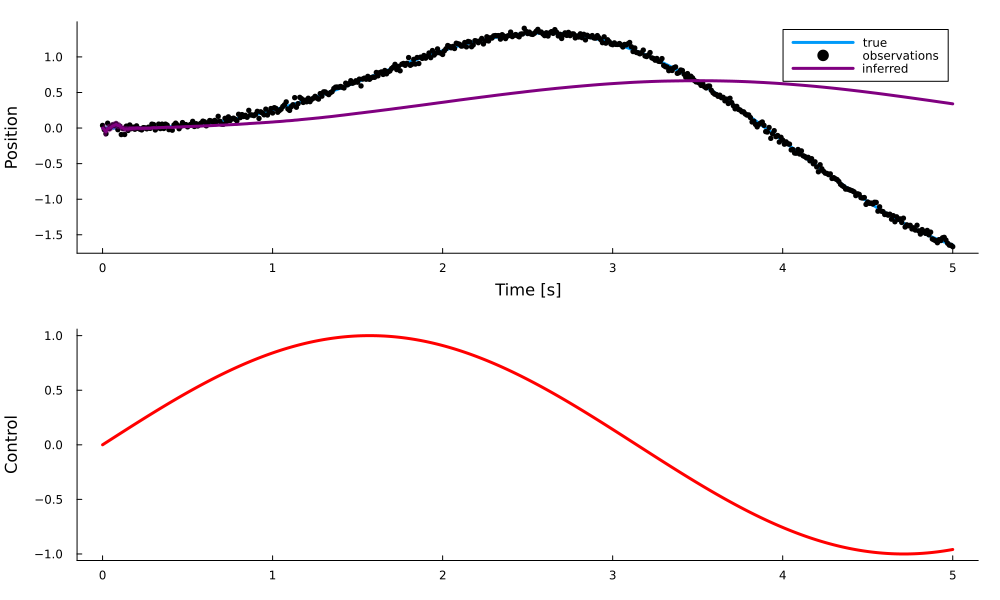

In [66]:
p301 = plot(time, z[1,:], label="true", ylabel="Position", xlabel="Time [s]")
scatter!(time, y, label="observations", color="black")
plot!(time, z_est[1][1,:], ribbon=3sqrt.(z_est[2][1,1,:]), label="inferred", color="purple")
p302 = plot(time, u, color="red", ylabel="Control")
plot(p301, p302, layout=(2,1), size=(1000,600))

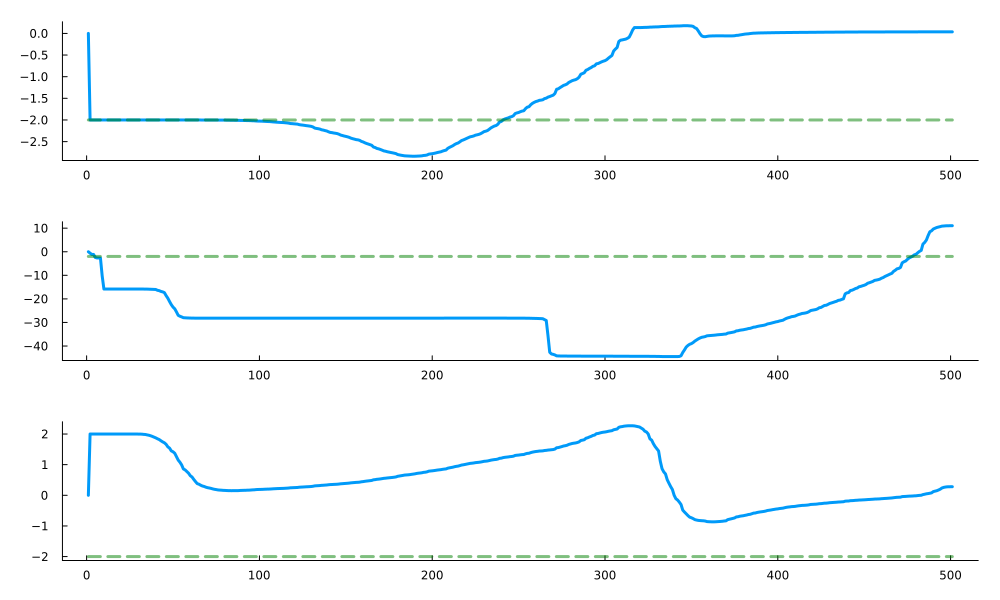

In [67]:
p401 = plot(θ_est[1][1,:], ribbon=sqrt.(θ_est[2][1,1,:]))
plot!(θ1_true*ones(len_time), color="green", linestyle=:dash, alpha=0.5, size=(1000,300))

p402 = plot(θ_est[1][2,:], ribbon=sqrt.(θ_est[2][2,2,:]))
plot!(θ1_true*ones(len_time), color="green", linestyle=:dash, alpha=0.5, size=(1000,300))

p403 = plot(θ_est[1][3,:], ribbon=sqrt.(θ_est[2][3,3,:]))
plot!(θ1_true*ones(len_time), color="green", linestyle=:dash, alpha=0.5, size=(1000,300))

plot(p401,p402,p403, layout=(3,1), size=(1000,600))

## RxInfer

In [70]:
using RxInfer